In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db

In [6]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [7]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [8]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [9]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [10]:
#streamlines_all = bn.read_sl('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk') 

In [11]:
'''streamlines_all_mni=[]
t=np.zeros([len(streamlines_all),3])
for i in range(len(streamlines_all)):
    tmp = streamlines_all[i]
    tmp2=np.zeros([len(tmp),3])
    tmp2[:,0] = tmp[:,0] * -1 + 90
    tmp2[:,1] = tmp[:,1] + 126
    tmp2[:,2] = tmp[:,2] + 72
    streamlines_all_mni.append(np.round(tmp2))
    t[i,0]=np.max(np.round(tmp2[:,0]))
    t[i,1]=np.max(np.round(tmp2[:,1]))
    t[i,2]=np.max(np.round(tmp2[:,2]))
'''

'streamlines_all_mni=[]\nt=np.zeros([len(streamlines_all),3])\nfor i in range(len(streamlines_all)):\n    tmp = streamlines_all[i]\n    tmp2=np.zeros([len(tmp),3])\n    tmp2[:,0] = tmp[:,0] * -1 + 90\n    tmp2[:,1] = tmp[:,1] + 126\n    tmp2[:,2] = tmp[:,2] + 72\n    streamlines_all_mni.append(np.round(tmp2))\n    t[i,0]=np.max(np.round(tmp2[:,0]))\n    t[i,1]=np.max(np.round(tmp2[:,1]))\n    t[i,2]=np.max(np.round(tmp2[:,2]))\n'

In [12]:
'''
streamline_all_bundle=np.zeros([len(streamlines_all),1])
n_streamlines = []
bundle_names = []
streamlines_seg = []
for f, fname in enumerate(bundle_files):
    print(f)
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    #streamlines_seg = streamlines_seg+streamlines
    for s_idx, s in enumerate(streamlines):
        for ss_idx, ss in enumerate(streamlines_all):
            if np.array_equal(s,ss):
                streamline_all_bundle[ss_idx]=f+1
                break
    n_streamlines.append(len(streamlines))
'''

"\nstreamline_all_bundle=np.zeros([len(streamlines_all),1])\nn_streamlines = []\nbundle_names = []\nstreamlines_seg = []\nfor f, fname in enumerate(bundle_files):\n    print(f)\n    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])\n    streamlines = bn.read_sl(fname) \n    #streamlines_seg = streamlines_seg+streamlines\n    for s_idx, s in enumerate(streamlines):\n        for ss_idx, ss in enumerate(streamlines_all):\n            if np.array_equal(s,ss):\n                streamline_all_bundle[ss_idx]=f+1\n                break\n    n_streamlines.append(len(streamlines))\n"

In [13]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [14]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [15]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0.2
val_perc=0.2
size_slimage = 100

In [16]:
import imp  
imp.reload(bn)

#if op.exists('./subject1_bundles.npz'):
    # Read it from file:
   # loaded_from_file = np.load('./subject1_bundles.npz')
    #labels_test = loaded_from_file['labels_test']
    #labels_val = loaded_from_file['labels_val']
    #labels_train = loaded_from_file['labels_train']
    #data_test = loaded_from_file['data_test']
   # data_val = loaded_from_file['data_val']
    #data_train = loaded_from_file['data_train']
#else:
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,5).compute() 
data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
np.savez('./atlas_bundles', data_train=data_train, labels_train=labels_train, data_val=data_val, labels_val=labels_val, data_test=data_test, labels_test=labels_test)

0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0
0
0
0
0
0
0
0


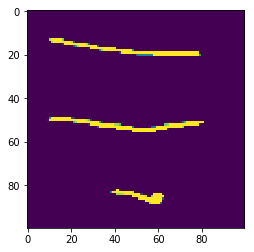

In [17]:
plt.imshow(streamlines_processed[5][1,:,:,0])

In [18]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels_train),
                                                 labels_train)

In [20]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [21]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [22]:
labels_train.shape


(734, 16)

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [24]:
from IPython.display import SVG
from keras.utils import plot_model
#from vis_utils import plot_model
plot_model(model, to_file='model.png')

In [25]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)

Train on 734 samples, validate on 245 samples
Epoch 1/16
734/734 [==============================] - 19s 25ms/step - loss: 0.3257 - acc: 0.8965 - val_loss: 0.0069 - val_acc: 0.9959

Epoch 00001: val_acc improved from -inf to 0.99592, saving model to checkpoints/weights.best.hdf5
Epoch 2/16
734/734 [==============================] - 16s 22ms/step - loss: 0.0184 - acc: 0.9946 - val_loss: 0.0054 - val_acc: 0.9959

Epoch 00002: val_acc did not improve from 0.99592
Epoch 3/16
734/734 [==============================] - 16s 22ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9959

Epoch 00003: val_acc did not improve from 0.99592
Epoch 4/16
734/734 [==============================] - 13s 18ms/step - loss: 2.1516e-04 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9959

Epoch 00004: val_acc did not improve from 0.99592
Epoch 5/16
734/734 [==============================] - 13s 17ms/step - loss: 2.2025e-04 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9959

Epoch 00005: val_acc di

In [28]:
model.load_weights("checkpoints/weights.best.hdf5")

In [29]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [30]:
print(score)

[0.008623131086909668, 0.9959183673469387]


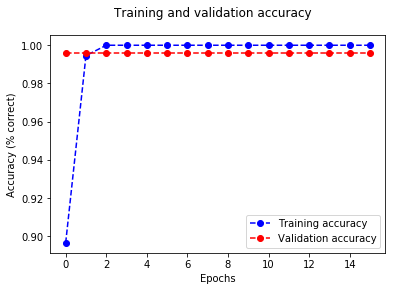

In [31]:
fig = bn.plot_accuracy(training)

In [32]:
p = model.predict(data_test, batch_size=5)

In [33]:
p_idx = np.argmax(p, axis=-1)
labels_test_idx = np.argmax(labels_test, axis=-1)

In [34]:
bn.print_accuarcystats(p_idx,labels_test_idx)

Percent correct is 0.9959183673469387 
Kappa is: 0.9956304619225967
Jaccard is: 0.9959183673469387


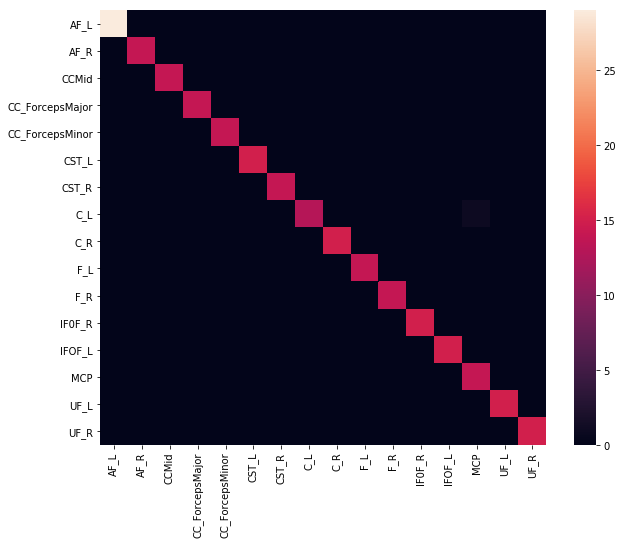

In [35]:
bn.plotconfusionmat(bundle_names, p_idx, labels_test_idx)

Cross-predict on *another subject*

In [36]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [37]:
streamlines_all = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 

In [38]:
'''import imp  
imp.reload(bn)
streamlines_processed=[]
for i in range(int(np.max(streamline_all_bundle))):
    print(i)
    indices = np.int_(np.where(streamline_all_bundle==i)[0])
    streamlines_tract = [streamlines_all[j] for j in indices]
    streamlines_processed_tract = bn.process_sl(streamlines_tract,take_n_sl,vol_shape,size_slimage,5)
    streamlines_processed.append(streamlines_processed_tract)
'''

'import imp  \nimp.reload(bn)\nstreamlines_processed=[]\nfor i in range(int(np.max(streamline_all_bundle))):\n    print(i)\n    indices = np.int_(np.where(streamline_all_bundle==i)[0])\n    streamlines_tract = [streamlines_all[j] for j in indices]\n    streamlines_processed_tract = bn.process_sl(streamlines_tract,take_n_sl,vol_shape,size_slimage,5)\n    streamlines_processed.append(streamlines_processed_tract)\n'

In [39]:
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_subj2 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_subj2 = np.append(labels_subj2,m_idx*np.ones([len(tmp),1]))
labels_subj2

array([ 0.,  0.,  0., ..., 15., 15., 15.])

In [40]:
ind = range(len(streamlines_all))
ind = np.delete(ind,map_file_index)
np.random.shuffle(ind)
unlabeled_streamlines = ind[0:len(map_file_index)]
labels_subj2 = np.append(labels_subj2,16*np.ones([len(map_file_index),1]))

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [41]:
labels_subj2

array([ 0.,  0.,  0., ..., 16., 16., 16.])

In [42]:
np.append(map_file_index,unlabeled_streamlines)

array([186748., 199724., 199806., ..., 198676., 205131.,  77989.])

In [43]:
streamlines_all_sub = [streamlines_all[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]
len(streamlines_all_sub)
len(labels_subj2)

57386

In [44]:
import imp  
imp.reload(bn)
streamlines_all_processed = bn.process_sl(streamlines_all_sub,-1,vol_shape_subj2,size_slimage,5)

0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [70]:
tmp1 = np.load(map_files[0])
tmp2 = np.load(map_files[1])
tmp = np.append(tmp1,tmp2)
streamlines_bund1 = [streamlines_all[i] for i in np.int_(tmp)]
streamlines_bund1_processed = bn.process_sl(streamlines_bund1,-1,vol_shape_subj2,size_slimage,5)

0


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1000


In [79]:
map_files

['/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_AF_L__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_AF_R__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_CCMid__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_CC_ForcepsMajor__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_CC_ForcepsMinor__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_CST_L__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_CST_R__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_C_L__labels.npy',
 '/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_C_R__labels.npy',
 '/home/ubuntu/recobundles/10030

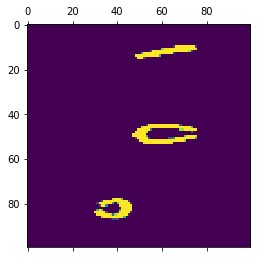

In [102]:
plt.matshow(streamlines_all_processed[10000,:,:,0])

In [103]:
p_subj2 = model.predict(streamlines_all_processed, batch_size=5)

In [104]:
p_idx = np.argmax(p_subj2, axis=-1)
max(p_idx)

15

In [105]:
bn.print_accuarcystats(p_idx[labels_subj2<16],labels_subj2[labels_subj2<16])

Percent correct is 0.983375736242289 
Kappa is: 0.9798212279488169
Jaccard is: 0.983375736242289


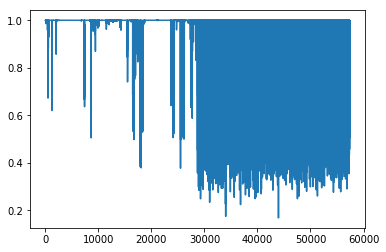

In [117]:
plt.plot(p_subj2.max(axis=1))

In [ ]:
np.sum(labels_subj2==0)

In [49]:
p_idx

array([ 9,  6,  0, ...,  4,  2, 13])

In [53]:
sum(p_idx[labels_subj2==0]==0)
len(p_idx[labels_subj2==0])

1527

In [ ]:
bn.plotconfusionmat(bundle_names, p_idx, labels_subj2)

In [ ]:
p_error = p_subj2[~(p_idx == all_labels)]
p_correct = p_subj2[p_idx == all_labels]

In [ ]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")

In [ ]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi

In [ ]:
import imp  
imp.reload(bn)

stan_loaded = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/CST_R.trk"]).map(bn.read_sl).compute()
stan_streamlines_processed = db.from_sequence(stan_loaded).map(bn.process_sl,size_slimage,vol_shape_dwi,size_slimage,5).compute() 
tmp = stan_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0))) 
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[10,:,:,:]))

In [ ]:
atlas_loaded = db.from_sequence([bundle_files[22]]).map(bn.read_sl).compute()
atlas_streamlines_processed = db.from_sequence(atlas_loaded).map(bn.process_sl,100,vol_shape,size_slimage,5).compute() 
tmp = atlas_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0)))
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[1,:,:,:]))

In [ ]:
for i, j in enumerate(bundle_files):
    print(i, j)

In [ ]:
bundle_files_afq = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/*.trk')

In [ ]:
streamlines_loaded_afq = db.from_sequence(bundle_files_afq).map(bn.read_sl).compute()

In [ ]:
del streamlines_processed_afq

In [ ]:
num_sl = 1000
streamlines_processed_afq = db.from_sequence(streamlines_loaded_afq).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage,5).compute() 

In [ ]:
len(streamlines_loaded_afq[19])

In [ ]:
all_streamlines_afq, all_labels_afq = bn.getdatafrombag(streamlines_processed_afq)

In [ ]:
p_afq = model.predict(all_streamlines_afq, batch_size=5)

In [ ]:
p_idx_afq = np.argmax(p_afq, axis=-1)

In [ ]:
bundle_names_afq = []
for fname in bundle_files_afq:
    bundle_names_afq.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq)):
    print("AFQ bundle= " + str(bundle_names_afq[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    unique, counts = np.unique(tmp, return_counts=True)
    ctsinds = counts.argsort()
    sorted_unique = unique[ctsinds[::-1]]
    m1 = sorted_unique[0]
    m2 = sorted_unique[1]
    print("Most likely bundle= " + str(bundle_names[m1]))
    print("2nd Most likely bundle= " + str(bundle_names[m2]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(tmp2)
    p2 = np.mean(tmp2[tmp==m1])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m1)
    print("Fraction of SLs with most likely class= " + str(c/num_sl))
    c = sum(tmp==m2)
    print("Fraction of SLs with 2nd most likely class= " + str(c/num_sl))
    print("        ")

In [ ]:
unique, counts = np.unique(tmp, return_counts=True)
counts
ctsinds = counts.argsort()
sorted_unique = unique[ctsinds[::-1]]
print(counts)
print(unique)
sorted_unique

In [ ]:
prob.shape

In [ ]:
bundle_files_afq2 = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/bundles/*.trk')
streamlines_loaded_afq2 = db.from_sequence(bundle_files_afq2).map(bn.read_sl).compute()
num_sl = 1000
streamlines_processed_afq2 = db.from_sequence(streamlines_loaded_afq2).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage,1).compute() 
all_streamlines_afq2, all_labels_afq2 = bn.getdatafrombag(streamlines_processed_afq2)
p_afq = model.predict(all_streamlines_afq2, batch_size=5)
p_idx_afq = np.argmax(p_afq, axis=-1)
bundle_names_afq2 = []
for fname in bundle_files_afq2:
    bundle_names_afq2.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq2)):
    print("AFQ bundle= " + str(bundle_names_afq2[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    m = stat.mode(tmp)
    print("Most likely bundle= " + str(bundle_names[m]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(prob[(num_sl*i):(num_sl-1)+(num_sl*i)])
    p2 = np.mean(tmp2[tmp==m])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m)
    print("Fraction of SLs with this most likely class= " + str(c/num_sl))
    print("        ")

In [ ]:
streamlines_loaded_afqall = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk"]).map(bn.read_sl).compute()

In [ ]:
sl = bn.read_sl("/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk")

In [ ]:
len(sl)

In [ ]:
streamlines_loaded_afqall = db.from_sequence([sl[0:10],sl[10:20]]).compute()

In [ ]:
streamlines_loaded_afqall = db.from_sequence([np.zeros([3,1]),np.zeros([3,1])]).compute()

In [ ]:
from AFQ.utils.parallel import parfor

In [ ]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi
num_sl=-1
size_slimage=100


In [ ]:
%time afq_all = parfor(bn.process_sl,[sl[i:i*30000] for i in range(10)],func_args=[num_sl,vol_shape_dwi,size_slimage,5],engine="dask")

In [ ]:
%time afq_all2 = bn.process_sl(sl[0:60000],num_sl,vol_shape_dwi,size_slimage,5)

In [ ]:
len(afq_all)

In [ ]:
plt.matshow(afq_all[0][1,:,:,:].squeeze()

In [ ]:
afq_all[0].shape